# Plot baseline results for topical decoding
In this notebook the results for the baseline in topical decoding are analysed

## Overview
1. Imports
    - 1.1. Import libraries
    - 1.2. Import model and tokenizer
    - 1.3. Import NEWTS dataset
    - 1.4. Import LDA model

2. Analyze the summaries

# 1. Imports

## 1.1 Import libraries

In [1]:
import sys
sys.path.append('../..')
import os, json
import matplotlib.pyplot as plt
import numpy as np
from utils.topical_evaluations import topic_scores
from rouge_score import rouge_scorer

## 1.2 Import results 

In [2]:
# Define the path to the data directory (relative to the current notebook's location)
data_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data/results_baseline')

# Define the full path to the summaries JSON file
summaries_file_path = os.path.join(data_dir, 'baseline_gemma_20.json')

# Read the JSON object from the file
with open(summaries_file_path, 'r') as f:
    summaries = json.load(f)

In [3]:
summaries[0]

{'tid1': 175,
 'tid2': 110,
 'no_focus': "\n\nSure, here's a summary of the article:\n\nThe World Bank's president, Jim Yong Kim, has warned the United States that it is days away from a dangerous moment due to the ongoing standoff over the debt ceiling. Failure to reach a resolution could result in interest rate hikes, falling confidence, and slowing growth. The US Treasury Secretary, Jacob Lew, has expressed concern that the government will exhaust its borrowing authority on Thursday and face the prospect of default if Congress does not raise the borrowing limit.\n\nThe IMF's policy-steering committee has expressed concerns about the US economy and the global economy, as the country's strong economy is a major driver of the global economy. The IMF has been forecasting that the strengthening US economy",
 'tid1_focus': "\n\nThe article discusses the dire situation the US is facing due to the standoff over the debt ceiling. The World Bank's President Jim Yong Kim warns that the US is d

In [9]:
len(summaries)

20

In [4]:
for article_idx, article_summaries in enumerate(summaries):
    print(f"Summaries for Article {article_idx}:")

    if 'no_focus' in article_summaries:
        print("Summary with no focus:")
        summary_text = article_summaries['no_focus']
        clean_summary_text = ' '.join(summary_text.strip().split())
        print(f"{clean_summary_text}\n")

    if 'tid1' in article_summaries and 'tid1_focus' in article_summaries:
        print(f"Summary with focus on tid1 =  {article_summaries['tid1']}")
        summary_text = article_summaries['tid1_focus']
        clean_summary_text = ' '.join(summary_text.strip().split())
        print(f"{clean_summary_text}\n")

    if 'tid2' in article_summaries and 'tid2_focus' in article_summaries:
        print(f"Summary with focus on tid2 =  {article_summaries['tid2']}")
        summary_text = article_summaries['tid2_focus']
        clean_summary_text = ' '.join(summary_text.strip().split())
        print(f"{clean_summary_text}\n")

    print("="*50 + "\n")

Summaries for Article 0:
Summary with no focus:
Sure, here's a summary of the article: The World Bank's president, Jim Yong Kim, has warned the United States that it is days away from a dangerous moment due to the ongoing standoff over the debt ceiling. Failure to reach a resolution could result in interest rate hikes, falling confidence, and slowing growth. The US Treasury Secretary, Jacob Lew, has expressed concern that the government will exhaust its borrowing authority on Thursday and face the prospect of default if Congress does not raise the borrowing limit. The IMF's policy-steering committee has expressed concerns about the US economy and the global economy, as the country's strong economy is a major driver of the global economy. The IMF has been forecasting that the strengthening US economy

Summary with focus on tid1 =  175
The article discusses the dire situation the US is facing due to the standoff over the debt ceiling. The World Bank's President Jim Yong Kim warns that th

## 1.3 Import the NEWTS dataset

In [5]:
from utils.newts_lda_utils import read_NEWTS_test, read_NEWTS_train

# Load the NEWTS training set
newts_train = read_NEWTS_train()
newts_test = read_NEWTS_test()

2024-03-25 20:13:38,655 - INFO - Data directory found at /Users/joschka/Documents/0_Studium/0_ML_Master/0_current_lectures/NLP_practical_project/local_topical_decoding/data.
2024-03-25 20:13:38,719 - INFO - Successfully loaded NEWTS training set.
2024-03-25 20:13:38,719 - INFO - Data directory found at /Users/joschka/Documents/0_Studium/0_ML_Master/0_current_lectures/NLP_practical_project/local_topical_decoding/data.
2024-03-25 20:13:38,740 - INFO - Successfully loaded NEWTS testing set.


## 1.4. Import LDA model

In [6]:
from utils.newts_lda_utils import read_LDA

# Load the LDA model and dictionary
lda, dictionary = read_LDA()
# Warning "WARNING:root:random_state not set so using default value" is inconsequential for inference

2024-03-25 20:13:40,123 - INFO - Data directory found at /Users/joschka/Documents/0_Studium/0_ML_Master/0_current_lectures/NLP_practical_project/local_topical_decoding/data.
2024-03-25 20:13:40,124 - INFO - loading LdaModel object from /Users/joschka/Documents/0_Studium/0_ML_Master/0_current_lectures/NLP_practical_project/local_topical_decoding/data/LDA_250/lda.model
2024-03-25 20:13:40,243 - INFO - loading id2word recursively from /Users/joschka/Documents/0_Studium/0_ML_Master/0_current_lectures/NLP_practical_project/local_topical_decoding/data/LDA_250/lda.model.id2word.* with mmap=r
2024-03-25 20:13:40,243 - INFO - loading expElogbeta from /Users/joschka/Documents/0_Studium/0_ML_Master/0_current_lectures/NLP_practical_project/local_topical_decoding/data/LDA_250/lda.model.expElogbeta.npy with mmap=r
2024-03-25 20:13:40,248 - INFO - setting ignored attribute state to None
2024-03-25 20:13:40,248 - INFO - setting ignored attribute dispatcher to None
2024-03-25 20:13:40,249 - INFO - LdaM

# 2. Analyse the summaries

## Calculate the Topic Scores

In [7]:
def calculate_topic_scores_for_all_summaries(summaries, lda, method="lemmatize", dictionary=None):
    """
    Calculate topic scores for the three types of summaries for both tid1 and tid2.
    
    :param summaries: List of dictionaries, each containing summaries for an article and its topic IDs.
    :param lda: The LDA model to use for calculating topic scores.
    :param method: Method used for text processing before calculating topic scores.
    :param dictionary: Dictionary used for LDA model.
    :return: Dictionary of scores categorized by focus type and topic ID.
    """

    scores = {
        "no_focus": {"tid1": [], "tid2": []},
        "tid1_focus": {"tid1": [], "tid2": []},
        "tid2_focus": {"tid1": [], "tid2": []}
    }
    
    for summary_info in summaries:
        tid1 = summary_info["tid1"]
        tid2 = summary_info["tid2"]
        tid1 = int(tid1)
        tid2 = int(tid2)
        
        for focus in ["no_focus", "tid1_focus", "tid2_focus"]:
            summary_text = summary_info[focus]
            # Calculate topic scores for tid1 and tid2
            score_tid1 = topic_scores(documents=[summary_text], lda=lda, tids=[tid1], method=method, dictionary=dictionary)[0]
            score_tid2 = topic_scores(documents=[summary_text], lda=lda, tids=[tid2], method=method, dictionary=dictionary)[0]
            
            # Store the scores
            scores[focus]["tid1"].append(score_tid1)
            scores[focus]["tid2"].append(score_tid2)
    
    return scores


In [8]:
# Calculate topic scores for all summaries
scores = calculate_topic_scores_for_all_summaries(summaries, lda, method="lemmatize", dictionary=dictionary)

In [18]:
def plot_topic_scores(scores, title):
    """
    Plot the average topic scores for tid1 and tid2, with improved labeling and ordering.

    :param scores: A dictionary with keys as focus types and values as dictionaries containing 'tid1' and 'tid2' scores.
    :param title: The title for the plot.
    """
    # Ordering and labeling adjustments
    focus_order = ['tid1_focus', 'no_focus', 'tid2_focus']  # Define the order
    focus_labels = ['TID1 Focus', 'No Focus', 'TID2 Focus']  # Human-readable labels
    
    # Calculate average scores for tid1 and tid2 according to the defined order
    avg_scores_tid1 = [np.mean(scores[focus]['tid1']) for focus in focus_order]
    avg_scores_tid2 = [np.mean(scores[focus]['tid2']) for focus in focus_order]
    
    x = np.arange(len(focus_order))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, avg_scores_tid1, width, label='TID1')
    rects2 = ax.bar(x + width/2, avg_scores_tid2, width, label='TID2')

    # Add some text for labels, title, and custom x-axis tick labels
    ax.set_xlabel('Summary Type')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(focus_labels)
    ax.legend()

    fig.tight_layout()
    plt.savefig('../../plots/baseline_gemma_20_topic_scores.png')
    plt.show()


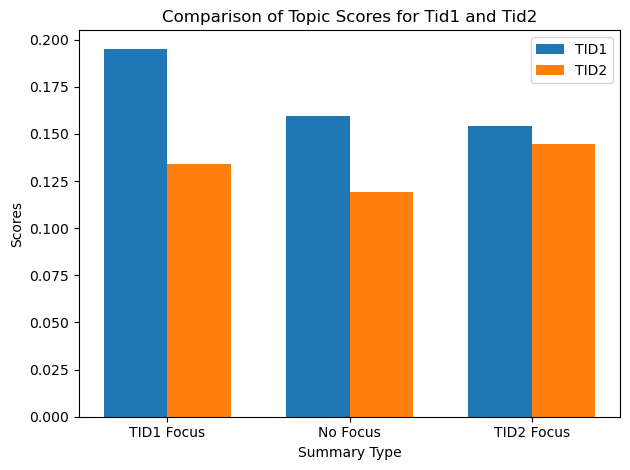

In [19]:
# Plot the scores for tid1 and tid2
plot_topic_scores(scores, 'Comparison of Topic Scores for Tid1 and Tid2')

In [13]:
def compute_rouge_scores(generated_summary, reference_summary):
    """
    Compute ROUGE-1, ROUGE-2, and ROUGE-L scores between a generated summary and a reference summary.
    
    :param generated_summary: The generated summary text.
    :param reference_summary: The reference summary text.
    :return: A dictionary with keys 'rouge1', 'rouge2', and 'rougeL' and values as the corresponding scores.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_summary, generated_summary)
    
    # Extract F1 scores for simplicity
    results = {key: score.fmeasure for key, score in scores.items()}
    return results


In [14]:
rouge_scores = []

# Assuming 'summaries' is your list of generated summaries for each article
for idx, summaries_for_article in enumerate(summaries):
    # Fetch reference summaries from newts_train by index
    # Ensure 'newts_train' is a DataFrame and its order corresponds to 'summaries'
    reference_summary1 = newts_train.iloc[idx]['summary1']
    reference_summary2 = newts_train.iloc[idx]['summary2']
    
    article_rouge_scores = {}
    
    for summary_type in ['no_focus', 'tid1_focus', 'tid2_focus']:
        generated_summary = summaries_for_article[summary_type]
        
        # Compute ROUGE scores against both reference summaries
        article_rouge_scores[summary_type] = {
            'summary1': compute_rouge_scores(generated_summary, reference_summary1),
            'summary2': compute_rouge_scores(generated_summary, reference_summary2)
        }
    
    rouge_scores.append(article_rouge_scores)

2024-03-25 20:16:33,906 - INFO - Using default tokenizer.
2024-03-25 20:16:33,977 - INFO - Using default tokenizer.
2024-03-25 20:16:33,980 - INFO - Using default tokenizer.
2024-03-25 20:16:33,982 - INFO - Using default tokenizer.
2024-03-25 20:16:33,984 - INFO - Using default tokenizer.
2024-03-25 20:16:33,986 - INFO - Using default tokenizer.
2024-03-25 20:16:33,988 - INFO - Using default tokenizer.
2024-03-25 20:16:33,989 - INFO - Using default tokenizer.
2024-03-25 20:16:33,991 - INFO - Using default tokenizer.
2024-03-25 20:16:33,992 - INFO - Using default tokenizer.
2024-03-25 20:16:33,994 - INFO - Using default tokenizer.
2024-03-25 20:16:33,995 - INFO - Using default tokenizer.
2024-03-25 20:16:33,996 - INFO - Using default tokenizer.
2024-03-25 20:16:33,998 - INFO - Using default tokenizer.
2024-03-25 20:16:34,000 - INFO - Using default tokenizer.
2024-03-25 20:16:34,001 - INFO - Using default tokenizer.
2024-03-25 20:16:34,003 - INFO - Using default tokenizer.
2024-03-25 20:

In [20]:
def plot_rouge_scores(rouge_scores):
    """
    Plot simplified ROUGE scores for each summary type, showing averaged scores for comparison against summary1 and summary2.
    
    :param rouge_scores: The computed ROUGE scores, structured as a list of dictionaries.
    """
    summary_types = ['tid1_focus', 'no_focus', 'tid2_focus']
    metrics = ['rouge1', 'rouge2', 'rougeL']
    colors = ['#1f77b4', '#ff7f0e']  # Different color for each reference summary
    
    # Initialize lists to hold averaged scores for each reference summary
    scores_summary1 = []
    scores_summary2 = []
    
    for stype in summary_types:
        rouge1_avg = np.mean([np.mean([article_scores[stype]['summary1'][metric] for metric in metrics]) for article_scores in rouge_scores])
        rouge2_avg = np.mean([np.mean([article_scores[stype]['summary2'][metric] for metric in metrics]) for article_scores in rouge_scores])
        
        scores_summary1.append(rouge1_avg)
        scores_summary2.append(rouge2_avg)
    
    x = np.arange(len(summary_types))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, scores_summary1, width, label='Summary1', color=colors[0])
    rects2 = ax.bar(x + width/2, scores_summary2, width, label='Summary2', color=colors[1])

    # Add some text for labels, title, and custom x-axis tick labels
    ax.set_ylabel('Average ROUGE Scores')
    ax.set_title('Average ROUGE Scores by Summary Type and Reference')
    ax.set_xticks(x)
    ax.set_xticklabels(['TID1 Focus', 'No Focus', 'TID2 Focus'])
    ax.legend()

    fig.tight_layout()
    plt.savefig('../../plots/baseline_gemma_20_rouge_scores.png')
    plt.show()


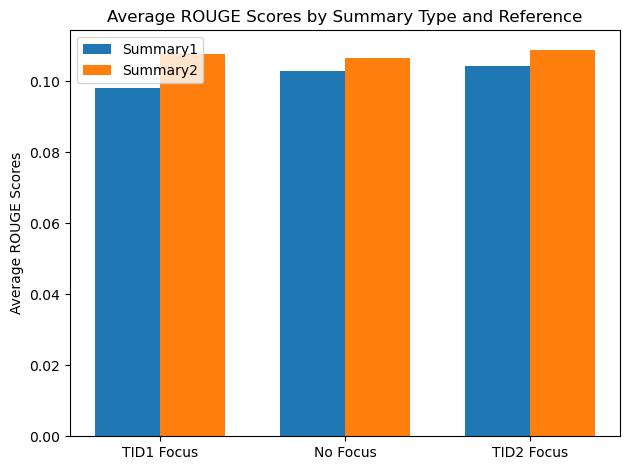

In [21]:
plot_rouge_scores(rouge_scores)